In [2]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from custom_loss import custom_loss_function
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# import custom_metric

2024-03-14 14:25:56.719804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 14:25:56.958874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 14:25:56.958922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-14 14:25:57.005992: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 14:25:57.841950: W tensorflow/stream_executor/platform/de

# Data creation and clean

In [4]:
# import data and check columns
df = pd.read_csv('../raw_data/final_df.csv')
df.columns

Index(['meeting_id', 'meeting_name', 'date', 'country_code', 'event_number',
       'distance', 'distance_unit', 'distance_furlongs',
       'distance_raw_furlongs', 'race_class',
       ...
       '10 mins', '5 mins', '3 mins', '2 mins', '1 min ', 'Post Time',
       'Last Traded Price', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max'],
      dtype='object', length=140)

In [12]:
#testing pipeline
from pipeline_cleaning import clean_data, transforming_data
df_clean= clean_data(df.copy())
df_transform = transforming_data(df_clean.copy())

In [10]:
type(df_transform[3])

sklearn.compose._column_transformer.ColumnTransformer

In [13]:
df_clean.columns

Index(['meeting_id', 'date', 'event_number', 'distance', 'race_class',
       'race_class_normalised', 'total_prize_money', 'track_condition',
       'race_type', 'track_type', 'barrier', 'finish_position', 'win_or_lose',
       'margin', 'gear', 'jockey_allowance', 'handicap_weight', 'jockey_id',
       'tainer_id', 'dslr', 'horse_id', 'wfa', 'weight_adjustment',
       'pre_race_master_rating_int', 'starting_price', 'place', 'runners',
       'min_price', 'max_price', 'bsp', '15_mins', '10_mins', '5_mins',
       '3_mins', '2_mins', '1_min_', 'post_time', 'last_traded_price',
       'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
       'rating_oficial', 'current_age'],
      dtype='object')

In [9]:
# train = df_transform[0]
# val = df_transform[1]
# test = df_transform[2]

In [10]:
# X_train = train.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
# X_val = val.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1)
# X_test = test.drop(columns = ['meeting_id', 'horse_id', 'event_number','bsp', 'win_or_lose', 'place','15_mins', '10_mins', '5_mins', '3_mins', '2_mins', '1_min_'], axis =1 )

In [14]:
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean.drop(columns=['jockey_id', 'tainer_id', 'margin', 'dslr','rating_oficial',
                    'last_traded_price', 'finish_position', #'event_number',
                    'pre_race_master_rating_int',
                    'post_time'], axis=1, inplace=True) # for now
df_clean.dropna(inplace=True) #instead of imputer for now
df_clean.drop_duplicates(inplace=True)
# df_train = df[(df['date'].dt.year != 2022) & (df['date'].dt.year != 2023)]
# df_val = df[df['date'].dt.year == 2022]
# df_test = df[df['date'].dt.year == 2023]
# df_train.drop(columns=['date'], axis=1, inplace=True)
# df_val.drop(columns=['date'], axis=1, inplace=True)
# df_test.drop(columns=['date'], axis=1, inplace=True)

df_clean

,meeting_id,date,event_number,distance,race_class,race_class_normalised,total_prize_money,track_condition,race_type,track_type,...,15_mins,10_mins,5_mins,3_mins,2_mins,1_min_,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,current_age
54106,28399,2021-08-20,4,1554,4,Novice,13771,STANDARD TO SLOW,FLAT,AWT,...,40.0,48.0,55.0,48.0,46.0,50.0,16.2,1.1,7.6,885.0
59709,28734,2021-09-15,4,1636,5,Novice,7377,SOFT,FLAT,TURF,...,90.0,70.0,50.0,70.0,75.0,80.0,14.9,0.1,9.1,911.0
63559,28895,2021-10-02,1,1540,4,Novice,9837,GOOD,FLAT,TURF,...,42.0,55.0,50.0,50.0,60.0,140.0,10.6,9.5,22.1,928.0
65634,29008,2021-10-13,4,1835,5,Handicap,5902,GOOD TO SOFT,FLAT,TURF,...,50.0,55.0,55.0,60.0,55.0,140.0,12.4,0.1,10.8,939.0
24837,26632,2021-04-12,3,1759,4,Handicap,7918,GOOD,FLAT,TURF,...,6.2,6.2,6.2,5.2,4.6,4.4,2.6,0.6,10.7,1125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103627,33246,2022-07-06,1,2871,6,Handicap,6787,GOOD,FLAT,TURF,...,75.0,85.0,70.0,70.0,65.0,65.0,16.0,0.0,14.3,1598.0
124494,34281,2022-10-10,1,3079,6,Handicap,6787,STANDARD,FLAT,AWT,...,120.0,170.0,190.0,120.0,140.0,95.0,10.2,5.9,13.5,1694.0
127552,34503,2022-10-27,3,3080,6,Handicap,7279,STANDARD,FLAT,AWT,...,14.0,13.5,14.5,13.0,13.0,19.0,16.0,4.3,18.0,1711.0
148364,36600,2023-05-04,7,3124,6,Handicap,7148,GOOD TO SOFT,FLAT,TURF,...,50.0,55.0,50.0,42.0,44.0,32.0,11.7,1.2,14.9,1900.0


In [18]:
df_clean.columns

Index(['meeting_id', 'date', 'event_number', 'distance', 'race_class',
       'race_class_normalised', 'total_prize_money', 'track_condition',
       'race_type', 'track_type', 'barrier', 'win_or_lose', 'gear',
       'jockey_allowance', 'handicap_weight', 'horse_id', 'wfa',
       'weight_adjustment', 'starting_price', 'place', 'runners', 'min_price',
       'max_price', 'bsp', '15_mins', '10_mins', '5_mins', '3_mins', '2_mins',
       '1_min_', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'current_age'],
      dtype='object')

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [19]:
from sklearn.model_selection import  train_test_split
X = df_clean[['distance', 'race_class',
       'race_class_normalised', 'total_prize_money', 'track_condition',
       'race_type', 'track_type', 'barrier', 'gear',
       'jockey_allowance', 'handicap_weight', 'wfa',
       'weight_adjustment', 'starting_price', 'runners', 'min_price',
       'max_price', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'current_age']]
y = df_clean[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0)

X

,distance,race_class,race_class_normalised,total_prize_money,track_condition,race_type,track_type,barrier,gear,jockey_allowance,...,wfa,weight_adjustment,starting_price,runners,min_price,max_price,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,current_age
54106,1554,4,Novice,13771,STANDARD TO SLOW,FLAT,AWT,3,0,0.0,...,0.0,9.0,29.0,8.0,46.00,1000.0,16.2,1.1,7.6,885.0
59709,1636,5,Novice,7377,SOFT,FLAT,TURF,4,0,0.0,...,0.0,11.0,67.0,10.0,90.00,1000.0,14.9,0.1,9.1,911.0
63559,1540,4,Novice,9837,GOOD,FLAT,TURF,7,0,0.0,...,0.0,9.0,67.0,9.0,60.00,1000.0,10.6,9.5,22.1,928.0
65634,1835,5,Handicap,5902,GOOD TO SOFT,FLAT,TURF,1,0,0.0,...,0.0,12.0,67.0,11.0,50.00,1000.0,12.4,0.1,10.8,939.0
24837,1759,4,Handicap,7918,GOOD,FLAT,TURF,2,0,0.0,...,0.0,8.0,3.5,8.0,1.01,6.0,2.6,0.6,10.7,1125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103627,2871,6,Handicap,6787,GOOD,FLAT,TURF,11,1,0.0,...,0.0,10.0,34.0,12.0,29.00,990.0,16.0,0.0,14.3,1598.0
124494,3079,6,Handicap,6787,STANDARD,FLAT,AWT,4,1,0.0,...,0.0,13.0,81.0,11.0,6.80,1000.0,10.2,5.9,13.5,1694.0
127552,3080,6,Handicap,7279,STANDARD,FLAT,AWT,7,1,0.0,...,0.0,11.0,19.0,9.0,11.50,1000.0,16.0,4.3,18.0,1711.0
148364,3124,6,Handicap,7148,GOOD TO SOFT,FLAT,TURF,9,1,0.0,...,0.0,19.0,29.0,10.0,8.60,1000.0,11.7,1.2,14.9,1900.0


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
y_train

,win_or_lose,1_min_
47393,0.0,17.50
158889,0.0,350.00
172266,0.0,32.00
167111,0.0,9.20
53199,0.0,4.10
...,...,...
97447,0.0,8.80
84263,1.0,7.00
44146,1.0,7.80
6672,0.0,60.00


<AxesSubplot:ylabel='Density'>

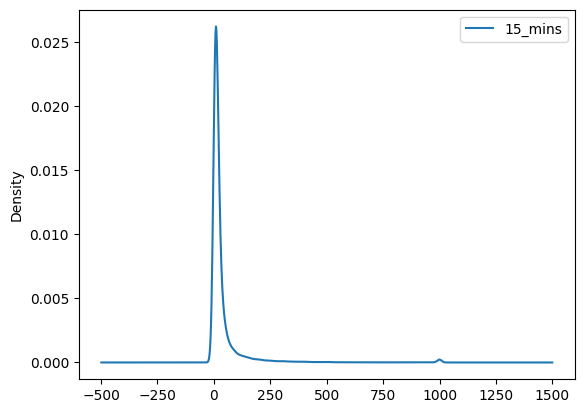

In [30]:
df_clean[['15_mins']].plot(kind='kde')

In [21]:
categorical_col = ['barrier', 'track_condition', 'race_type', 'track_type',
                    'race_class_normalised', 'race_class']
num_col = ['distance', 'total_prize_money', 'jockey_allowance', 'handicap_weight',   'wfa',
            'weight_adjustment', 'starting_price', 'current_age',
            'min_price', 'max_price','runners', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max']

categorical_preprocessor = Pipeline([
('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])
numerical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
pipeline = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_col),
    ('numerical', numerical_preprocessor, num_col)
], remainder="passthrough", sparse_threshold=0)

In [97]:
pipeline

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['barrier', 'track_condition', 'race_type',
                                  'track_type', 'race_class_normalised',
                                  'race_class']),
                                ('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['distance', 'total_prize_money',
                                  'jockey_allowance', 'handicap_weight', 'wfa',
                                  'weight_adjustment', 'starting_price',
                                  'current_age', 'min_price', 'max_price',
                                  'runners', 'temperature_2m_mean',
                                  'precipitation_sum', 'wind_speed_10m_max'])])

In [46]:

pipeline.fit(x_train)
x_train_transformed = pipeline.transform(x_train)
x_val_transformed = pipeline.transform(x_val)
x_test_transformed = pipeline.transform(x_test)

categorical_feature_names = pipeline.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(input_features=categorical_col)

numerical_feature_names = num_col
remainder_col_names = [col for col in x_train.columns if col not in (num_col+categorical_col)]

all_feature_names = list(categorical_feature_names) + numerical_feature_names + remainder_col_names



In [102]:
pipeline

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['barrier', 'track_condition', 'race_type',
                                  'track_type', 'race_class_normalised',
                                  'race_class']),
                                ('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['distance', 'total_prize_money',
                                  'jockey_allowance', 'handicap_weight', 'wfa',
                                  'weight_adjustment', 'starting_price',
                                  'current_age', 'min_price', 'max_price',
                                  'runners', 'temperature_2m_mean',
                                  'precipitation_sum', 'wind_speed_10m_max'])])

In [108]:
import pickle
with open('softmax_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)


In [109]:

pipe2 = pickle.load(open('softmax_pipeline.pkl', 'rb'))
pipe2

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['barrier', 'track_condition', 'race_type',
                                  'track_type', 'race_class_normalised',
                                  'race_class']),
                                ('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['distance', 'total_prize_money',
                                  'jockey_allowance', 'handicap_weight', 'wfa',
                                  'weight_adjustment', 'starting_price',
                                  'current_age', 'min_price', 'max_price',
                                  'runners', 'temperature_2m_mean',
                                  'precipitation_sum', 'wind_speed_10m_max'])])

In [111]:
!pip freeze | grep learn

imbalanced-learn==0.9.1
imblearn==0.0
scikit-learn==1.2.1


In [110]:
pipe2.get_feature_names_out()

array(['categorical__barrier_1', 'categorical__barrier_2',
       'categorical__barrier_3', 'categorical__barrier_4',
       'categorical__barrier_5', 'categorical__barrier_6',
       'categorical__barrier_7', 'categorical__barrier_8',
       'categorical__barrier_9', 'categorical__barrier_10',
       'categorical__barrier_11', 'categorical__barrier_12',
       'categorical__barrier_13', 'categorical__barrier_14',
       'categorical__barrier_15', 'categorical__barrier_16',
       'categorical__barrier_17', 'categorical__barrier_18',
       'categorical__barrier_19', 'categorical__barrier_20',
       'categorical__track_condition_FAST',
       'categorical__track_condition_FIRM',
       'categorical__track_condition_GOOD',
       'categorical__track_condition_GOOD TO FIRM',
       'categorical__track_condition_GOOD TO SOFT',
       'categorical__track_condition_GOOD TO YIELDING',
       'categorical__track_condition_HEAVY',
       'categorical__track_condition_SOFT',
       'categorica

In [88]:
pd.Series(pipeline.get_feature_names_out()).str.split('__', expand=True)[1]

0               barrier_1
1               barrier_2
2               barrier_3
3               barrier_4
4               barrier_5
             ...         
62                runners
63    temperature_2m_mean
64      precipitation_sum
65     wind_speed_10m_max
66                   gear
Name: 1, Length: 67, dtype: object

In [37]:
pd.DataFrame({'feature_names': all_feature_names, 'pipeline_features':pipeline.get_feature_names_out()})


,feature_names,pipeline_features
0,barrier_1,categorical__barrier_1
1,barrier_2,categorical__barrier_2
2,barrier_3,categorical__barrier_3
3,barrier_4,categorical__barrier_4
4,barrier_5,categorical__barrier_5
...,...,...
62,runners,numerical__runners
63,temperature_2m_mean,numerical__temperature_2m_mean
64,precipitation_sum,numerical__precipitation_sum
65,wind_speed_10m_max,numerical__wind_speed_10m_max


In [47]:
df_train_transformed_with_columns = pd.DataFrame(x_train_transformed, columns=all_feature_names)
df_val_transformed_with_columns = pd.DataFrame(x_val_transformed, columns=all_feature_names)
df_test_transformed_with_columns = pd.DataFrame(x_test_transformed, columns=all_feature_names)

# df_train_transformed_with_columns[numerical_feature_names] = df_train_transformed_with_columns[numerical_feature_names].astype(float)
# df_train_transformed_with_columns[categorical_feature_names] = df_train_transformed_with_columns[categorical_feature_names].astype(int)
# df_val_transformed_with_columns[numerical_feature_names] = df_val_transformed_with_columns[numerical_feature_names].astype(float)
# df_val_transformed_with_columns[categorical_feature_names] = df_val_transformed_with_columns[categorical_feature_names].astype(int)
# df_test_transformed_with_columns[numerical_feature_names] = df_test_transformed_with_columns[numerical_feature_names].astype(float)
# df_test_transformed_with_columns[categorical_feature_names] = df_test_transformed_with_columns[categorical_feature_names].astype(int)

barrier_1              float64
barrier_2              float64
barrier_3              float64
barrier_4              float64
barrier_5              float64
                        ...   
runners                float64
temperature_2m_mean    float64
precipitation_sum      float64
wind_speed_10m_max     float64
gear                   float64
Length: 67, dtype: object

In [11]:
# X_train.shape, X_val.shape, X_test.shape

((73401, 66), (56804, 66), (40350, 66))

In [42]:
# X_train

,barrier_1,barrier_2,barrier_3,barrier_4,barrier_5,barrier_6,barrier_7,barrier_8,barrier_9,barrier_10,...,weight_adjustment,starting_price,current_age,min_price,max_price,runners,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,gear
0,0,0,1,0,0,0,0,0,0,0,...,-0.395887,0.085578,-1.053312,0.167277,0.425851,-0.678297,0.995120,-0.317643,-1.096076,0.0
1,0,0,0,1,0,0,0,0,0,0,...,-0.047512,0.981491,-1.015499,0.612941,0.425851,-0.048197,0.742134,-0.566062,-0.795570,0.0
2,0,0,0,0,0,0,1,0,0,0,...,-0.395887,0.981491,-0.990775,0.309079,0.425851,-0.363247,-0.094664,1.769083,1.808814,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.126676,0.981491,-0.974778,0.207792,0.425851,0.266853,0.255623,-0.566062,-0.454997,0.0
4,0,1,0,0,0,0,0,0,0,0,...,-0.570074,-0.515626,-0.704270,-0.288414,-2.573518,-0.678297,-1.651499,-0.441852,-0.475030,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73396,0,0,0,0,0,0,0,0,0,0,...,-1.963575,-0.397743,2.621811,-0.223691,0.425851,0.266853,1.442709,-0.566062,-0.434963,1.0
73397,0,1,0,0,0,0,0,0,0,0,...,-0.744262,0.604265,1.718664,0.714228,0.425851,-0.048197,0.742134,-0.541220,1.929016,0.0
73398,0,0,0,0,0,0,0,0,0,0,...,2.042739,-0.103035,-0.414856,-0.223691,0.274977,0.266853,0.275084,2.613709,1.989117,0.0
73399,0,0,0,0,0,0,0,0,1,0,...,2.042739,-0.421320,-0.347956,-0.229768,0.425851,-0.363247,-0.191967,-0.590904,-0.374862,0.0


In [13]:
# y_train = np.array(train[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
# y_val = np.array(val[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))
# y_test = np.array(test[['win_or_lose', '1_min_']].replace({'win_or_lose':0.5}, 1.0))

In [14]:
# test[['win_or_lose']].replace({'win_or_lose':0.5}, 1.0).value_counts()

win_or_lose
0.0            35788
1.0             4562
dtype: int64

# Model - Custom Loss Softmax

In [41]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),
    keras.metrics.Accuracy(name='accuracy'),
    # keras.metrics.F1Score(name='f1_score')
    # keras.metrics.F1   # precision-recall curve add precsion, F1, accuracy
    
]
#change to mse, mae, rmse

2024-03-14 15:39:11.308217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:39:11.334802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-14 15:39:11.334973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-14 15:39:11.335192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-14 15:39:11.335398: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [42]:
#build model
def inititialize_model_softmax(X_train):

    #architecture
#   normaliser = Normalization() -suggestion to do normalization on target (y)
    model = models.Sequential()
    model.add(layers.Dense(1000, activation = 'relu', input_dim=X_train.shape[-1]))
    model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(500, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(100, activation = 'relu'))
    # model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(2, activation = 'softmax'))
    
    # classification comilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss=custom_loss_function,
              optimizer=optimizer, 
              metrics=metrics)
    return model

In [48]:
#initialize model
model_softmax = inititialize_model_softmax(df_train_transformed_with_columns)
model_softmax.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1000)              68000     
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 70,002
Trainable params: 70,002
Non-trainable params: 0
_________________________________________________________________


In [49]:
# X_train.columns

In [50]:
es = EarlyStopping(patience=3, monitor="val_loss")
# Train the model
history = model_softmax.fit(df_train_transformed_with_columns, y_train,
                    validation_data = (df_val_transformed_with_columns, y_val),
                    epochs=15, #increase number of epochs
                    batch_size=32, 
                    callbacks=[es])

Epoch 1/15
3412/3412 [==============================] - 19s 4ms/step - loss: -0.0730 - recall: 0.8557 - precision: 0.9513 - prc: 0.9310 - accuracy: 0.0000e+00 - val_loss: -0.0815 - val_recall: 0.8646 - val_precision: 0.9610 - val_prc: 0.9405 - val_accuracy: 0.0000e+00
Epoch 2/15
3412/3412 [==============================] - 15s 4ms/step - loss: -0.0805 - recall: 0.8647 - precision: 0.9613 - prc: 0.9368 - accuracy: 0.0000e+00 - val_loss: -0.0819 - val_recall: 0.8642 - val_precision: 0.9606 - val_prc: 0.9359 - val_accuracy: 0.0000e+00
Epoch 3/15
3412/3412 [==============================] - 15s 4ms/step - loss: -0.0812 - recall: 0.8647 - precision: 0.9613 - prc: 0.9353 - accuracy: 0.0000e+00 - val_loss: -0.0819 - val_recall: 0.8658 - val_precision: 0.9623 - val_prc: 0.9401 - val_accuracy: 0.0000e+00
Epoch 4/15
3412/3412 [==============================] - 15s 4ms/step - loss: -0.0816 - recall: 0.8659 - precision: 0.9626 - prc: 0.9375 - accuracy: 0.0000e+00 - val_loss: -0.0819 - val_recall: 

In [51]:
y_test_pred = model_softmax.predict(df_test_transformed_with_columns, verbose=0)

In [93]:
model_softmax.save('softmax.h5')

In [95]:
df_train_transformed_with_columns.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_GOOD TO YIELDING', 'track_condition_HEAVY',
       'track_condition_SOFT', 'track_condition_STANDARD',
       'track_condition_STANDARD TO FAST', 'track_condition_STANDARD TO SLOW',
       'race_type_NATIONAL_HUNT_FLAT', 'track_type_TURF',
       'race_class_normalised_Claiming', 'race_class_normalised_Conditions',
       'race_class_normalised_Grade 1', 'race_class_normalised_Grade 2',
       'race_class_normalised_Group 1', 'race_class_normalised_Group 2',
       'race_class_normalised_Group 3', 'race_class_normalised_H

In [52]:
results_df = pd.DataFrame({'y_pred': y_test_pred.round(2)[:,0], 'y_true': y_test['win_or_lose']})
results_df

,y_pred,y_true
14174,0.0,0.0
131589,0.0,0.0
165401,0.0,0.0
99935,0.0,0.0
123141,0.0,0.0
...,...,...
48293,1.0,1.0
69070,0.0,0.0
55061,0.0,0.0
114994,0.0,0.0


In [53]:
results_df.y_true.value_counts()

0.0    30310
1.0     3801
Name: y_true, dtype: int64

In [54]:
results_df['y_pred_050'] = results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
results_df.y_pred_050.value_counts()

0.0    29107
1.0     5004
Name: y_pred_050, dtype: int64

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
scores = {
    'accuracy': [accuracy_score(results_df.y_true, results_df.y_pred_050)],
    'precision': [precision_score(results_df.y_true, results_df.y_pred_050)],
    'recall': [recall_score(results_df.y_true, results_df.y_pred_050)],
    'f1': [f1_score(results_df.y_true, results_df.y_pred_050)]
}
scores_df = pd.DataFrame(scores)
scores_df

,accuracy,precision,recall,f1
0,0.963267,0.754596,0.993423,0.857694


In [56]:
model_softmax.evaluate(df_test_transformed_with_columns, y_test)

1066/1066 [==============================] - 3s 2ms/step - loss: -0.0795 - recall: 0.8674 - precision: 0.9640 - prc: 0.9381 - accuracy: 1.3192e-04


[-0.07953298836946487,
 0.8673771023750305,
 0.9640291929244995,
 0.9381334781646729,
 0.00013192225014790893]

In [57]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.title('Model Accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='best')
    # plt.show()

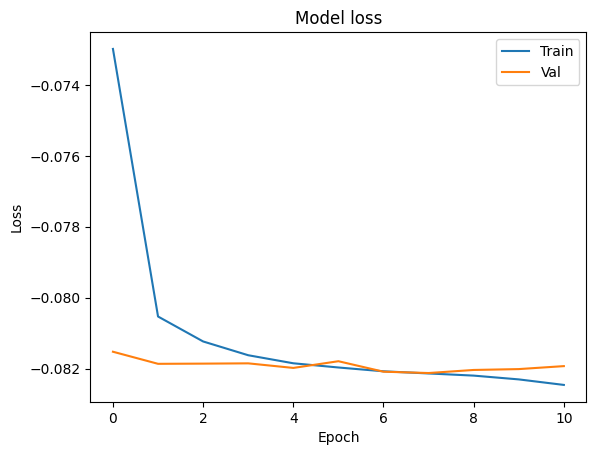

In [113]:
plot_loss_accuracy(history)

In [60]:
test = pd.concat([x_test,y_test], axis=1)
test.columns

Index(['distance', 'race_class', 'race_class_normalised', 'total_prize_money',
       'track_condition', 'race_type', 'track_type', 'barrier', 'gear',
       'jockey_allowance', 'handicap_weight', 'wfa', 'weight_adjustment',
       'starting_price', 'runners', 'min_price', 'max_price',
       'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
       'current_age', 'win_or_lose', '1_min_'],
      dtype='object')

In [29]:
test_results_df = test.copy()[['meeting_id', 'event_number',
       'place', 
       #'15_mins', '10_mins', '5_mins', '3_mins', '2_mins',
       '1_min_', 'win_or_lose']]

test_results_df['race_id'] = test_results_df['meeting_id'].astype(str) + '_' + test_results_df['event_number'].astype(str)
test_results_df['y_pred'] = results_df['y_pred']
test_results_df['bet'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.5 else 0.0)
test_results_df['bet_075'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.75 else 0.0)
test_results_df['bet_080'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.80 else 0.0)
test_results_df['bet_090'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.90 else 0.0)
test_results_df['bet_095'] = test_results_df.y_pred.map(lambda x: 1.0 if x>=0.95 else 0.0)
test_results_df['profit_050'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet']
test_results_df['profit_075'] = test_results_df['profit_050']*test_results_df['bet_075']
test_results_df['profit_080'] = test_results_df['profit_050']*test_results_df['bet_080']
test_results_df['profit_090'] = test_results_df['profit_050']*test_results_df['bet_090']
test_results_df['profit_095'] = test_results_df['profit_050']*test_results_df['bet_095']
test_results_df = test_results_df.sort_values(by='race_id')

In [30]:
random_bet = []
for race in sorted(set(test_results_df.race_id)):
    n_runners = test_results_df.race_id.value_counts()[race]
    ls = list(np.zeros(n_runners))
    ls[np.random.randint(0, n_runners)] = 1.0
    random_bet+=ls
random_bet

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [31]:
best_odds_bet = []
for race in sorted(set(test_results_df.race_id)):
    sub_df = test_results_df[test_results_df.race_id==race].reset_index()
    odds_ls = list(sub_df['1_min_'])
    n_runners = len(sub_df)
    ls = list(np.zeros(n_runners))
    ls[odds_ls.index(min(odds_ls))] = 1.0
    best_odds_bet+=ls
best_odds_bet

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0

In [32]:
test_results_df['bet_random'] = random_bet
test_results_df['profit_random'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_random']
test_results_df['bet_best_odds'] = best_odds_bet
test_results_df['profit_best_odds'] = (test_results_df['1_min_']*test_results_df['win_or_lose'] - 1)*test_results_df['bet_best_odds']

In [33]:
X_train.columns

Index(['barrier_1', 'barrier_2', 'barrier_3', 'barrier_4', 'barrier_5',
       'barrier_6', 'barrier_7', 'barrier_8', 'barrier_9', 'barrier_10',
       'barrier_11', 'barrier_12', 'barrier_13', 'barrier_14', 'barrier_15',
       'barrier_16', 'barrier_17', 'barrier_18', 'barrier_19', 'barrier_20',
       'track_condition_FAST', 'track_condition_FIRM', 'track_condition_GOOD',
       'track_condition_GOOD TO FIRM', 'track_condition_GOOD TO SOFT',
       'track_condition_HEAVY', 'track_condition_SOFT',
       'track_condition_STANDARD', 'track_condition_STANDARD TO FAST',
       'track_condition_STANDARD TO SLOW', 'race_type_NATIONAL_HUNT_FLAT',
       'track_type_TURF', 'race_class_normalised_Claiming',
       'race_class_normalised_Conditions', 'race_class_normalised_Grade 1',
       'race_class_normalised_Grade 2', 'race_class_normalised_Group 1',
       'race_class_normalised_Group 2', 'race_class_normalised_Group 3',
       'race_class_normalised_Handicap', 'race_class_normalised_Lis

In [34]:
test_results_df.head(50)

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.70,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
12897,35179.0,7.0,9.0,340.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9587,35179.0,7.0,10.0,20.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
17586,35179.0,7.0,8.0,70.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
27302,35179.0,7.0,13.0,9.60,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
24315,35179.0,7.0,4.0,10.50,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
22589,35179.0,7.0,2.0,4.50,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.00,-1.00,-1.00,-1.00,-1.00,0.0,-0.0,1.0,-1.00
7143,35179.0,7.0,7.0,10.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
8212,35179.0,7.0,5.0,190.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00
9849,35179.0,7.0,6.0,36.00,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,-0.0,0.0,-0.00


In [35]:
test_results_df[(test_results_df.win_or_lose==0.0)&(test_results_df.bet_080==0.0 )&(test_results_df.bet==1.0 )]

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
38300,35280.0,4.0,2.0,6.20,0.0,35280.0_4.0,0.67,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
4089,35426.0,3.0,2.0,2.06,0.0,35426.0_3.0,0.69,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
32217,35472.0,7.0,3.0,5.30,0.0,35472.0_7.0,0.56,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
32727,35509.0,3.0,4.0,36.00,0.0,35509.0_3.0,0.78,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17807,35579.0,6.0,2.0,3.15,0.0,35579.0_6.0,0.53,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
30836,35670.0,7.0,4.0,4.80,0.0,35670.0_7.0,0.62,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0
20853,36239.0,4.0,2.0,6.20,0.0,36239.0_4.0,0.73,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
30826,36291.0,5.0,2.0,2.70,0.0,36291.0_5.0,0.76,1.0,1.0,0.0,...,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
40203,36390.0,1.0,4.0,8.20,0.0,36390.0_1.0,0.50,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
40285,36496.0,1.0,2.0,4.70,0.0,36496.0_1.0,0.73,1.0,0.0,0.0,...,0.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-1.0


In [36]:
test_results_df[test_results_df.race_id=='35179.0_7.0']

,meeting_id,event_number,place,1_min_,win_or_lose,race_id,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
8555,35179.0,7.0,3.0,4.7,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
12897,35179.0,7.0,9.0,340.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9587,35179.0,7.0,10.0,20.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
17586,35179.0,7.0,8.0,70.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
27302,35179.0,7.0,13.0,9.6,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
24315,35179.0,7.0,4.0,10.5,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
22589,35179.0,7.0,2.0,4.5,0.0,35179.0_7.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-0.0,1.0,-1.0
7143,35179.0,7.0,7.0,10.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
8212,35179.0,7.0,5.0,190.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
9849,35179.0,7.0,6.0,36.0,0.0,35179.0_7.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0


In [37]:
race_results = test_results_df.groupby(by='race_id', as_index=False).sum()
race_results

,race_id,meeting_id,event_number,place,1_min_,win_or_lose,y_pred,bet,bet_075,bet_080,...,bet_095,profit_050,profit_075,profit_080,profit_090,profit_095,bet_random,profit_random,bet_best_odds,profit_best_odds
0,35179.0_7.0,492506.0,98.0,105.0,998.30,1.0,2.00,2.0,2.0,2.0,...,2.0,11.00,11.00,11.00,11.00,11.00,1.0,-1.0,1.0,-1.00
1,35180.0_7.0,281440.0,56.0,127.0,239.20,1.0,1.00,1.0,1.0,1.0,...,1.0,0.70,0.70,0.70,0.70,0.70,1.0,-1.0,1.0,0.70
2,35184.0_1.0,316656.0,9.0,45.0,135.64,1.0,1.00,1.0,1.0,1.0,...,1.0,1.84,1.84,1.84,1.84,1.84,1.0,-1.0,1.0,1.84
3,35184.0_2.0,351840.0,20.0,55.0,1181.79,1.0,1.00,1.0,1.0,1.0,...,1.0,0.89,0.89,0.89,0.89,0.89,1.0,-1.0,1.0,0.89
4,35184.0_3.0,387024.0,33.0,66.0,247.80,1.0,1.00,1.0,1.0,1.0,...,1.0,6.60,6.60,6.60,6.60,6.60,1.0,-1.0,1.0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,37729.0_2.0,415019.0,22.0,66.0,2211.81,1.0,2.00,2.0,2.0,2.0,...,2.0,-0.49,-0.49,-0.49,-0.49,-0.49,1.0,-1.0,1.0,0.51
4557,37729.0_3.0,415019.0,33.0,66.0,436.60,1.0,1.00,1.0,1.0,1.0,...,1.0,2.70,2.70,2.70,2.70,2.70,1.0,-1.0,1.0,2.70
4558,37729.0_4.0,301832.0,32.0,36.0,84.80,1.0,1.00,1.0,1.0,1.0,...,1.0,4.50,4.50,4.50,4.50,4.50,1.0,-1.0,1.0,-1.00
4559,37729.0_5.0,339561.0,45.0,45.0,132.35,1.0,1.75,2.0,2.0,2.0,...,0.0,17.50,17.50,17.50,18.50,0.00,1.0,-1.0,1.0,-1.00


In [38]:
race_results.columns

Index(['race_id', 'meeting_id', 'event_number', 'place', '1_min_',
       'win_or_lose', 'y_pred', 'bet', 'bet_075', 'bet_080', 'bet_090',
       'bet_095', 'profit_050', 'profit_075', 'profit_080', 'profit_090',
       'profit_095', 'bet_random', 'profit_random', 'bet_best_odds',
       'profit_best_odds'],
      dtype='object')

In [39]:
profit_trend_df = race_results[['profit_050', 'profit_075', 'profit_080', 'profit_090', 'profit_095', 'profit_random', 'profit_best_odds']].cumsum()
profit_trend_df

,profit_050,profit_075,profit_080,profit_090,profit_095,profit_random,profit_best_odds
0,11.000,11.000,11.000,11.000,11.000,-1.00,-1.00
1,11.700,11.700,11.700,11.700,11.700,-2.00,-0.30
2,13.540,13.540,13.540,13.540,13.540,-3.00,1.54
3,14.430,14.430,14.430,14.430,14.430,-4.00,2.43
4,21.030,21.030,21.030,21.030,21.030,-5.00,1.43
...,...,...,...,...,...,...,...
4556,33029.235,32933.035,32913.035,32724.635,32730.915,-489.64,-52.76
4557,33031.935,32935.735,32915.735,32727.335,32733.615,-490.64,-50.06
4558,33036.435,32940.235,32920.235,32731.835,32738.115,-491.64,-51.06
4559,33053.935,32957.735,32937.735,32750.335,32738.115,-492.64,-52.06


<AxesSubplot:>

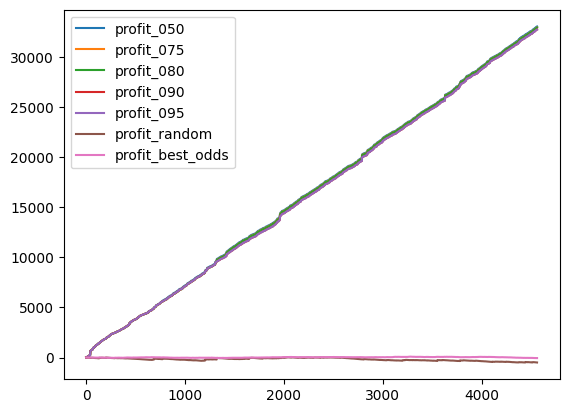

In [40]:
profit_trend_df.plot(kind='line')

<AxesSubplot:xlabel='y_pred', ylabel='Count'>

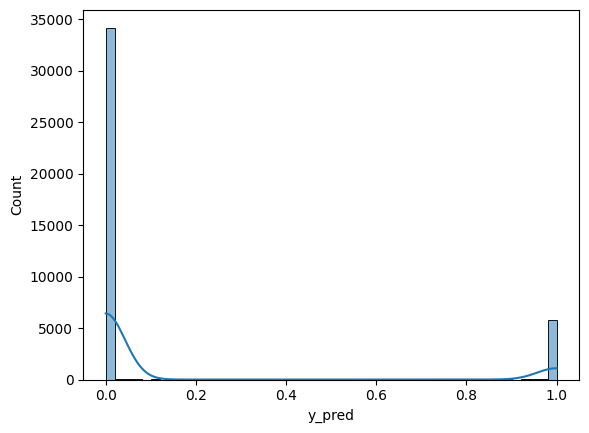

In [41]:
fiplt.subplot()
sns.histplot(test_results_df.y_pred, bins= 50, kde =True)